In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

print(os.cpu_count())

import gc
import re
import math
from glob import glob
import wandb

wandb.require("core")

import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import h5py
from PIL import Image
from io import BytesIO

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.optim as optim
from torch import nn
from torchvision import models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torcheval.metrics.functional import binary_auroc

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

import albumentations as A
from albumentations.pytorch import ToTensorV2

from colorama import Fore, Style

b_ = Fore.BLUE
sr_ = Style.RESET_ALL

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

30


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.13 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


Using cuda device


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.set_float32_matmul_precision("highest")


# Set the random seed
set_seed(42)

In [4]:
train_metadata_df = pd.read_csv("../data/stratified_4_fold.csv")
train_metadata_df.head()

,isic_id,target,fold
0,ISIC_0015670,0,3
1,ISIC_0015845,0,0
2,ISIC_0015864,0,3
3,ISIC_0015902,0,0
4,ISIC_0024200,0,1


In [5]:
class SkinDataset(Dataset):
    def __init__(self, df: pd.DataFrame, file_hdf: str, transform=None):
        assert "isic_id" in df.columns
        assert "target" in df.columns

        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df["isic_id"].values
        self.labels = df.target.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx: int):
        isic_id = self.isic_ids[idx]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        label = self.labels[idx] / 1.0
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def get_class_samples(self, class_label):
        indices = [i for i, label in enumerate(self.labels) if label == class_label]
        return indices


transforms_valid = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2(),
    ]
)

/home/ubuntu/.local/lib/python3.10/site-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, json-or-python[json=list[float], python=list[float]]]` but got `tuple` - serialized value may not be as expected
  Expected `Union[float, json-or-python[json=list[float], python=list[float]]]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [6]:
class SkinClassifier(nn.Module):
    def __init__(self, model_name="resnet18", freeze_backbone=False, bias_value=None):
        super(SkinClassifier, self).__init__()

        # Load the specified pre-trained model
        if model_name == "resnet18":
            self.backbone = models.resnet18(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.fc.in_features
            self.backbone.fc = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "convnext_tiny":
            self.backbone = models.convnext_tiny(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[2].in_features
            self.backbone.classifier[2] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "efficientnet_v2_s":
            self.backbone = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "efficientnet_v2_m":
            self.backbone = models.efficientnet_v2_m(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[1].in_features
            self.backbone.classifier[1] = self.get_clf_head(num_ftrs, 1, bias_value)
        elif model_name == "mobilenet_v3_small":
            self.backbone = models.mobilenet_v3_small(weights="IMAGENET1K_V1")
            if freeze_backbone:
                self.freeze_backbone()
            num_ftrs = self.backbone.classifier[3].in_features
            self.backbone.classifier[3] = self.get_clf_head(num_ftrs, 1, bias_value)
        else:
            raise ValueError(f"Model {model_name} not supported")

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

        for param in self.backbone.features[6].parameters():
            param.requires_grad = True

        for param in self.backbone.features[7].parameters():
            param.requires_grad = True

    def get_clf_head(self, in_features, out_features, bias_value=None):
        head = nn.Linear(in_features, out_features)
        if bias_value:
            nn.init.constant_(head.bias, bias_value)
        return head

    def count_parameters(self):
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        non_trainable_params = sum(
            p.numel() for p in self.parameters() if not p.requires_grad
        )
        return trainable_params, non_trainable_params

In [7]:
def get_dataloaders_and_stats(fold):
    valid_df = train_metadata_df.loc[train_metadata_df.fold == fold]

    num_workers = 24  # based on profiling

    file_hdf = "/home/ubuntu/ayusht/skin/data/train-image.hdf5"
    valid_dataset = SkinDataset(valid_df, file_hdf, transform=transforms_valid)
    dataset_sizes = {"val": len(valid_dataset)}
    print(dataset_sizes)

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
    )

    return valid_dataloader

In [8]:
model_files = glob("../models/*.bin")

def filter_files_by_run_id(files, run_id):
    """
    Filters the list of files by the given run ID.

    Args:
    files (list of str): List of file paths.
    run_id (str): The run ID to filter by.

    Returns:
    list of str: List of file paths that contain the specified run ID.
    """
    pattern = re.compile(rf"_{run_id}_")
    filtered_files = [file for file in files if pattern.search(file)]
    return filtered_files


def extract_valid_loss(file_name):
    """
    Extracts the valid_loss value from the given file name.

    Args:
    file_name (str): The file name from which to extract the valid_loss.

    Returns:
    float: The extracted valid_loss value.
    """
    match = re.search(r'valid_loss([\d\.]+)', file_name)
    if match:
        return float(match.group(1))
    return float('inf')  # Return a very high value if valid_loss is not found

def sort_files_by_valid_loss(files):
    """
    Sorts the list of files by the valid_loss value in the file names.

    Args:
    files (list of str): List of file paths to sort.

    Returns:
    list of str: Sorted list of file paths by valid_loss.
    """
    return sorted(files, key=extract_valid_loss)


@torch.inference_mode()
def infer_model(model, dataloader):
    model.eval()

    preds = []
    gts = []

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).flatten()

        with torch.no_grad():
            outputs = model(inputs).flatten()
            preds.extend(torch.sigmoid(outputs))
            gts.extend(labels)

    preds = [pred.item() for pred in preds]
    gts = [gt.item() for gt in gts]

    return preds, gts


def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [9]:
def log_positive_dist(preds):
    positive_preds = np.array(preds)[np.array(gts) == 1.0]

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.hist(positive_preds, bins=100)
    plt.title('Prediction Distribution for Positive Class')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')

    return plt


def log_negative_dist(preds):
    negative_preds = np.array(preds)[np.array(gts) == 0.0]

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.hist(negative_preds, bins=100)
    plt.title('Prediction Distribution for Negative Class')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')

    return plt

{'val': 108226}


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 846/846 [01:47<00:00,  7.89it/s]


AUROC,▁
pAUC,▁
AUROC,0.94327
pAUC,0.1611


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 846/846 [01:47<00:00,  7.90it/s]


AUROC,▁
pAUC,▁
AUROC,0.93058
pAUC,0.15245


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 846/846 [01:47<00:00,  7.89it/s]


AUROC,▁
pAUC,▁
AUROC,0.92802
pAUC,0.14987


{'val': 98031}


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 766/766 [01:41<00:00,  7.57it/s]


AUROC,▁
pAUC,▁
AUROC,0.92515
pAUC,0.14746


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 766/766 [01:39<00:00,  7.69it/s]


AUROC,▁
pAUC,▁
AUROC,0.92589
pAUC,0.14665


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 766/766 [01:40<00:00,  7.65it/s]


AUROC,▁
pAUC,▁
AUROC,0.92797
pAUC,0.15161


{'val': 93952}


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 734/734 [01:38<00:00,  7.45it/s]


AUROC,▁
pAUC,▁
AUROC,0.93268
pAUC,0.15598


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 734/734 [01:35<00:00,  7.71it/s]


AUROC,▁
pAUC,▁
AUROC,0.93338
pAUC,0.15959


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 734/734 [01:35<00:00,  7.67it/s]


AUROC,▁
pAUC,▁
AUROC,0.92014
pAUC,0.15198


{'val': 100850}


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 788/788 [01:42<00:00,  7.71it/s]


AUROC,▁
pAUC,▁
AUROC,0.91083
pAUC,0.13065


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 788/788 [01:40<00:00,  7.81it/s]
/tmp/ipykernel_1787958/1156507050.py

AUROC,▁
pAUC,▁
AUROC,0.91453
pAUC,0.13205


/tmp/ipykernel_1787958/3040625476.py:28: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

100%|██████████| 788/788 [01:41<00:00,  7.77it/s]


AUROC,▁
pAUC,▁
AUROC,0.91009
pAUC,0.12915


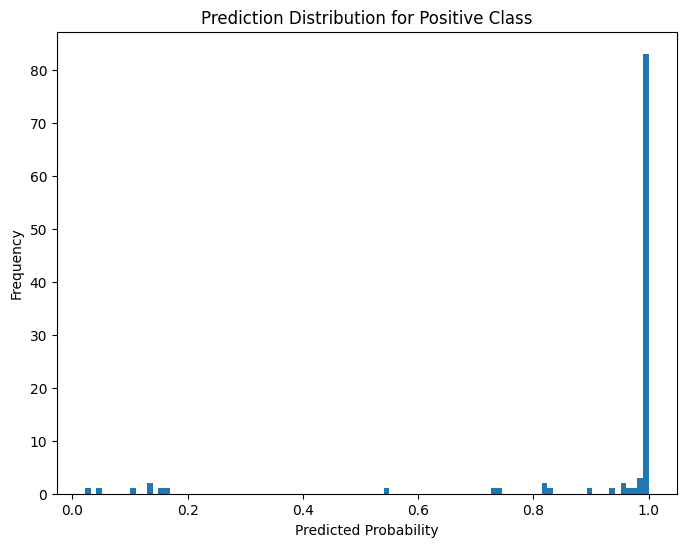

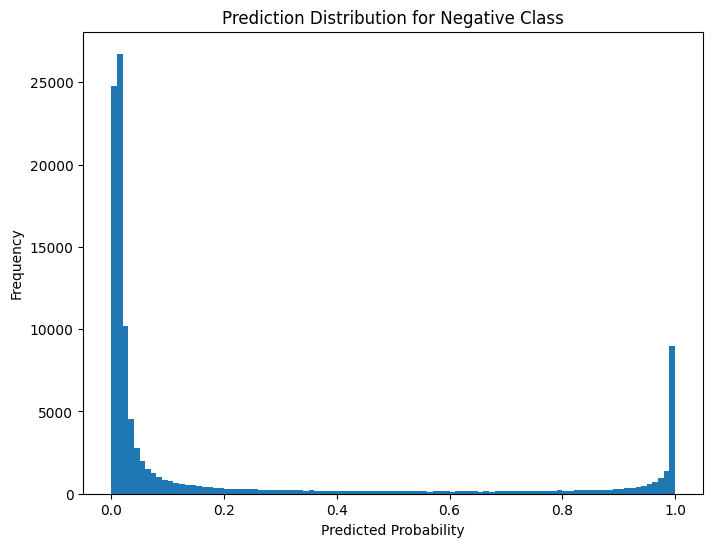

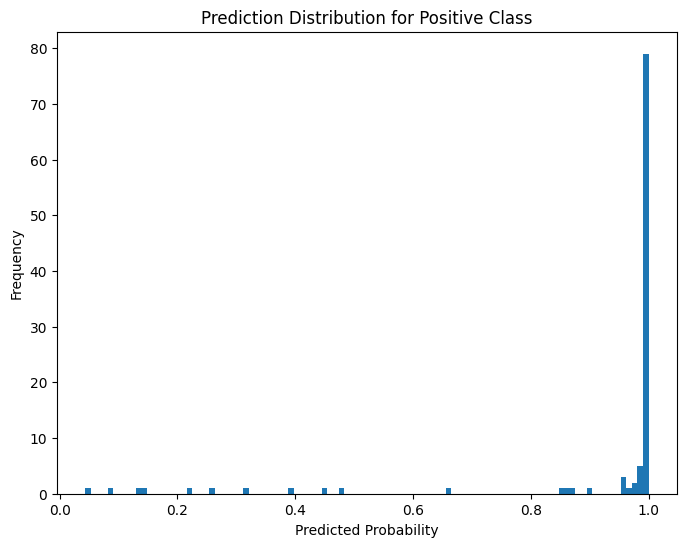

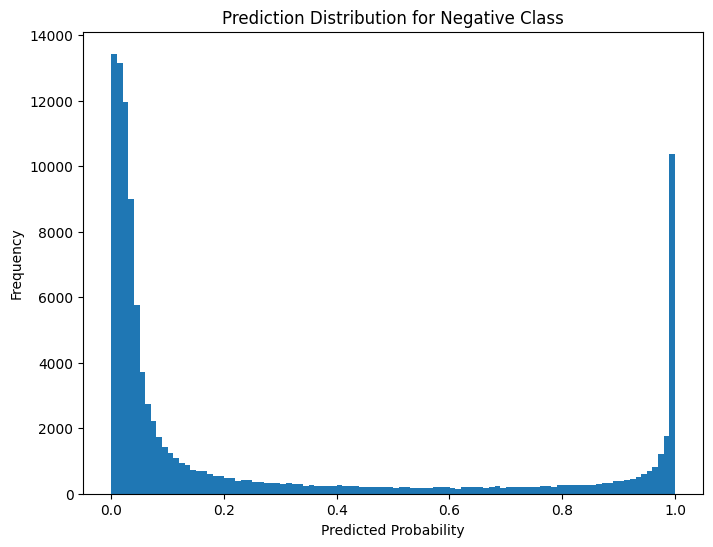

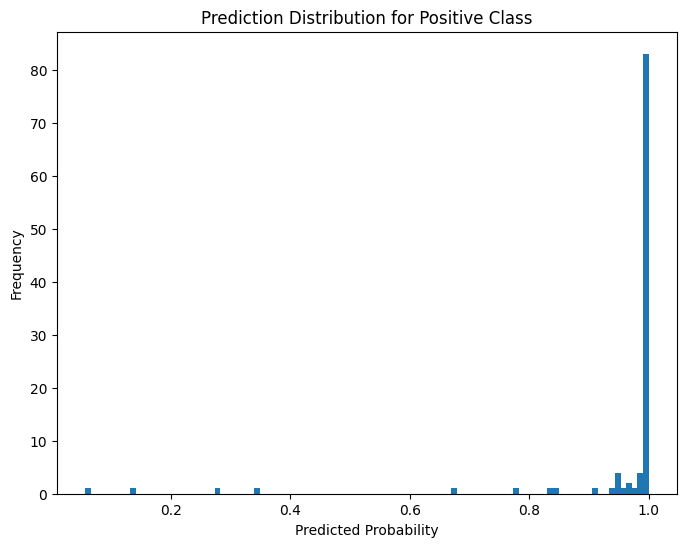

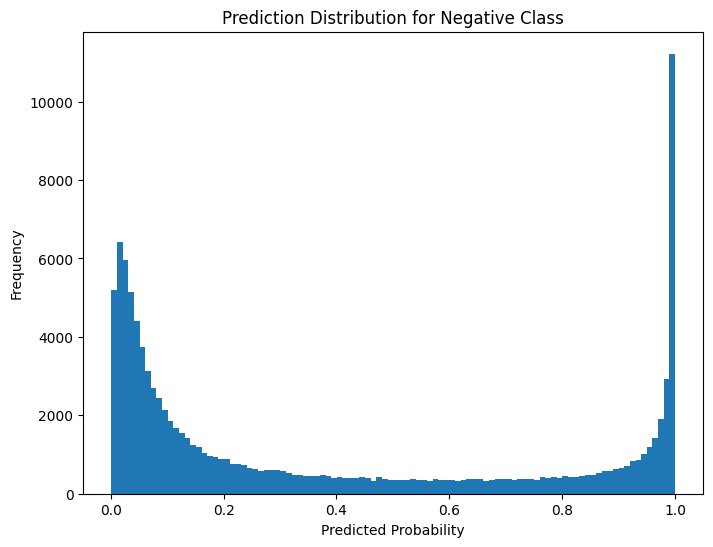

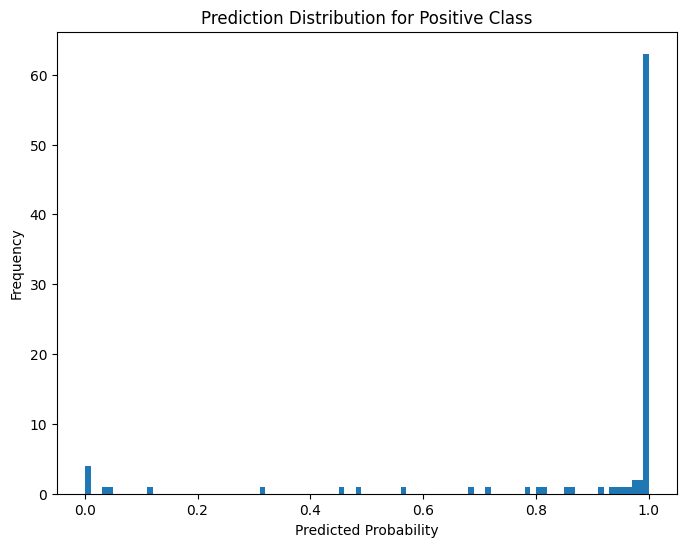

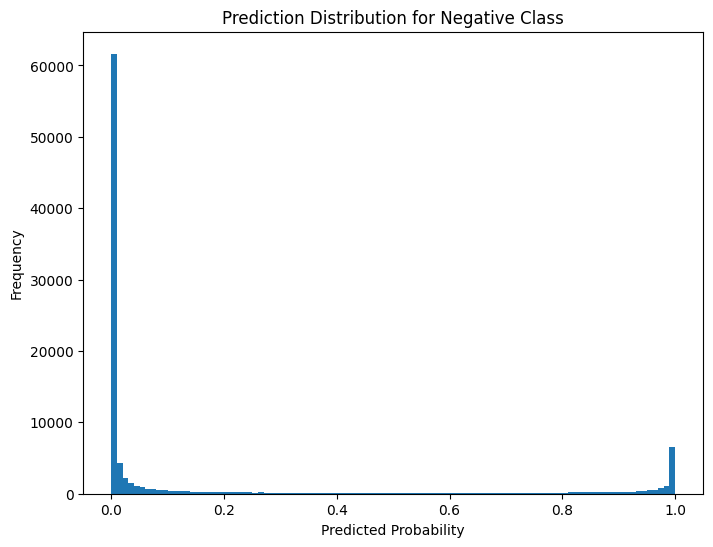

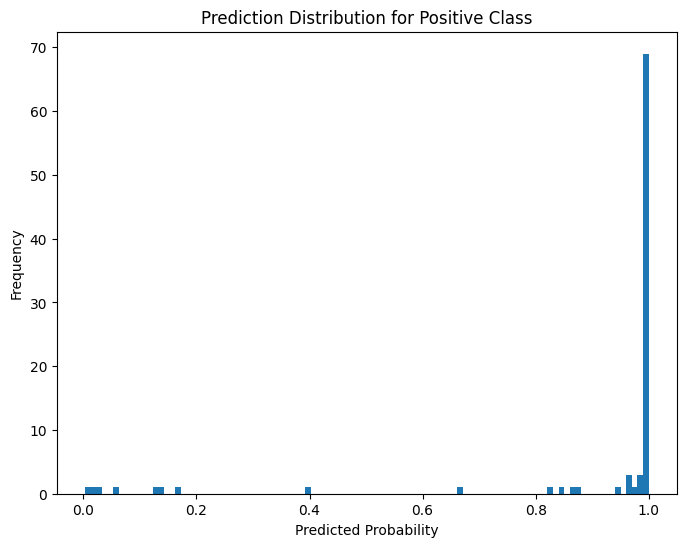

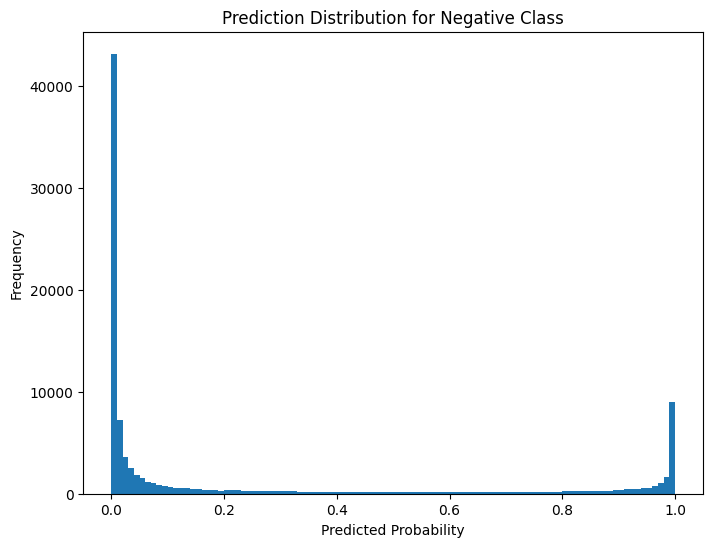

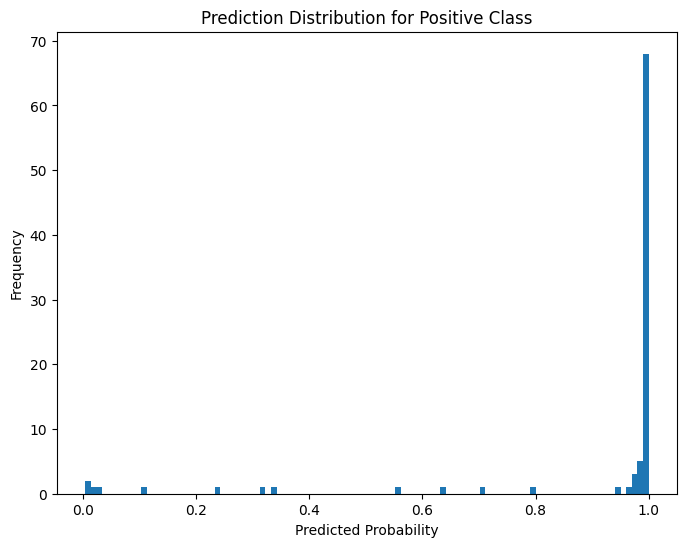

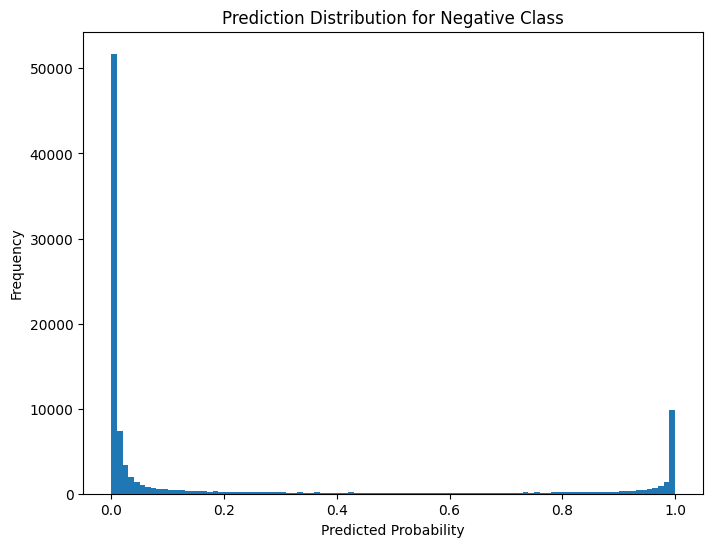

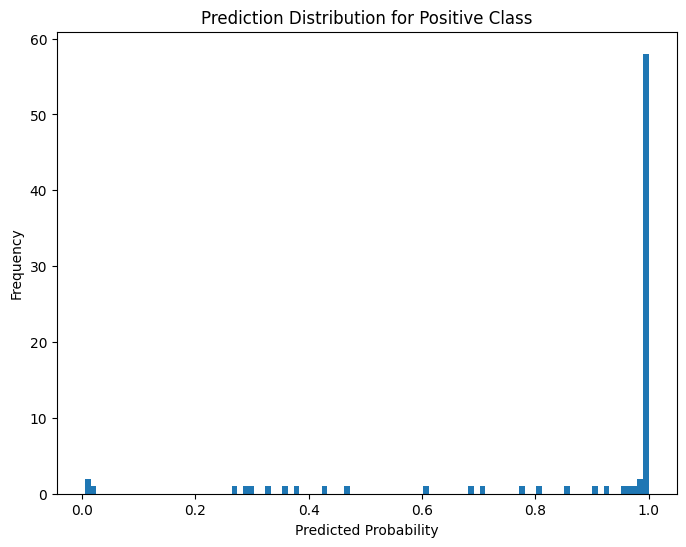

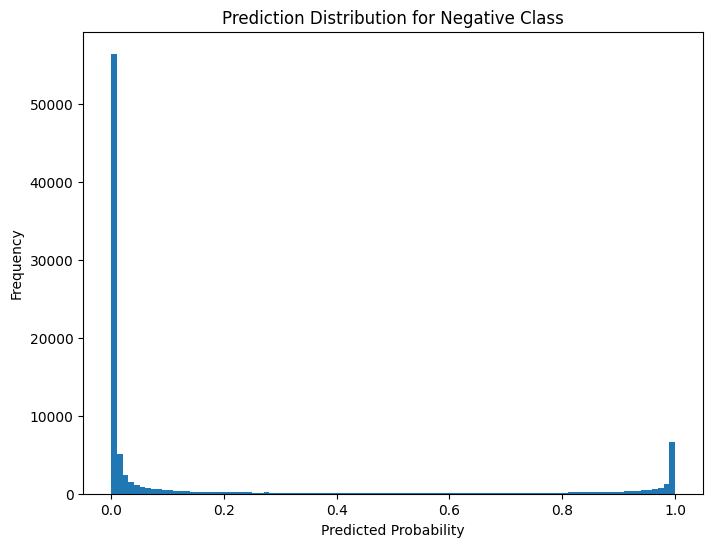

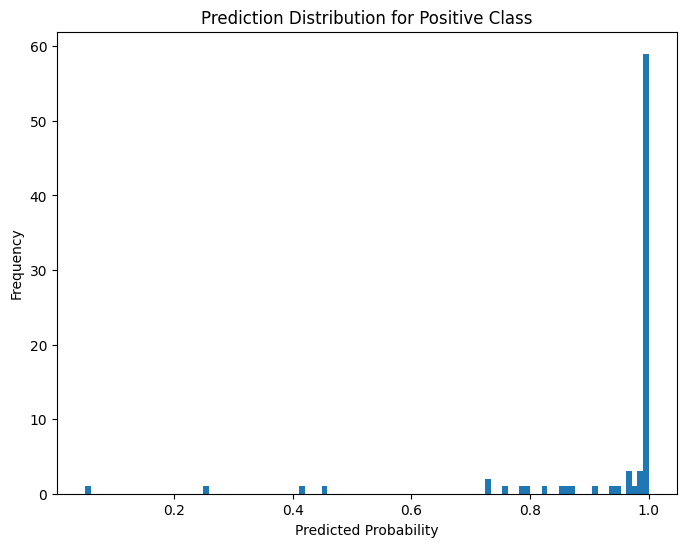

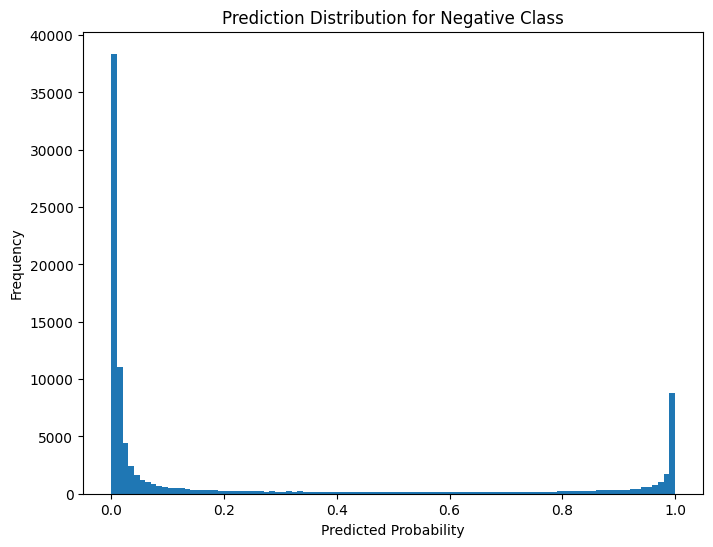

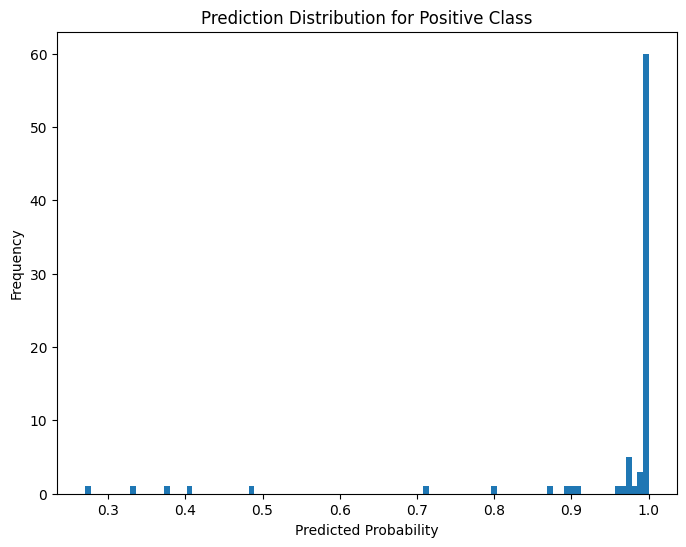

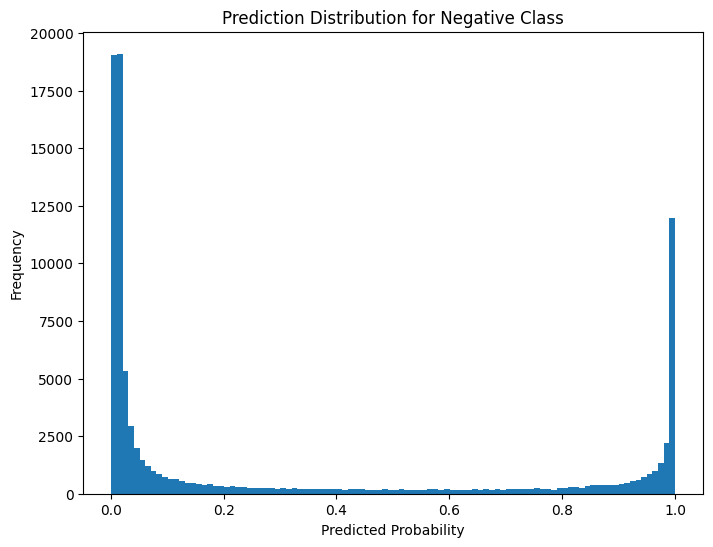

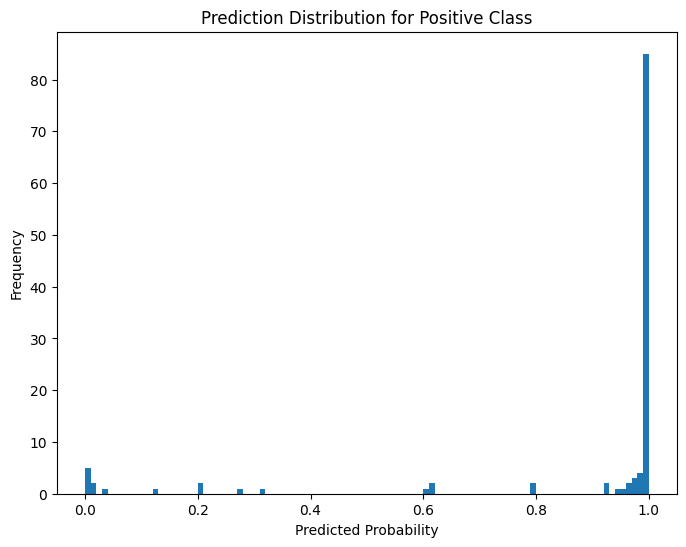

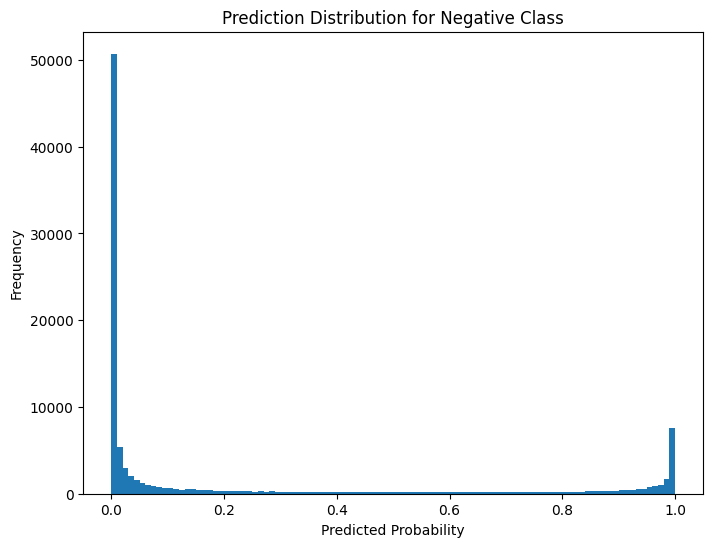

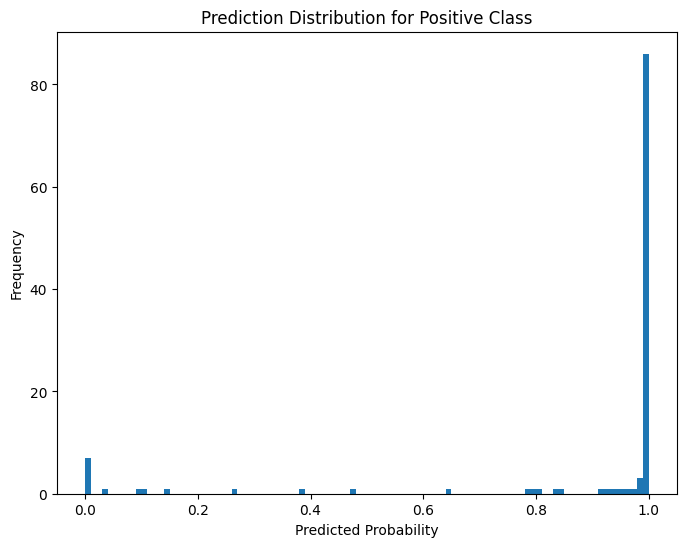

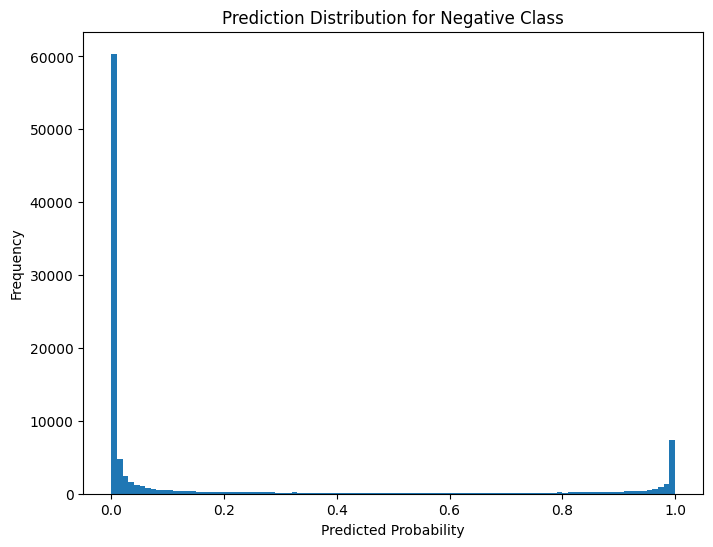

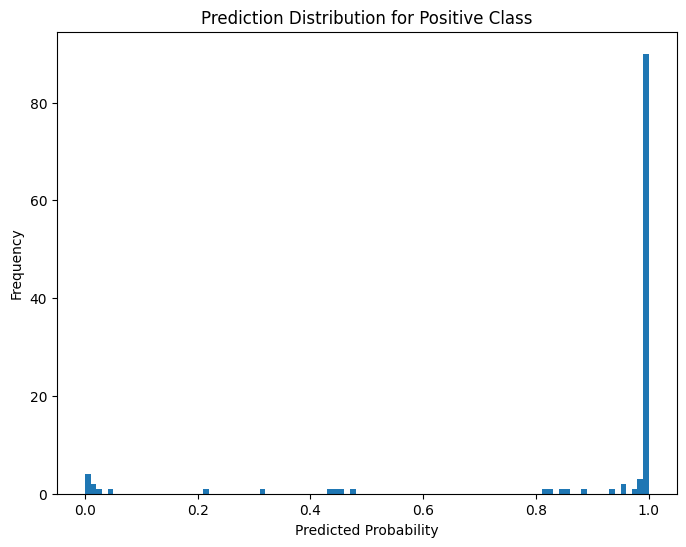

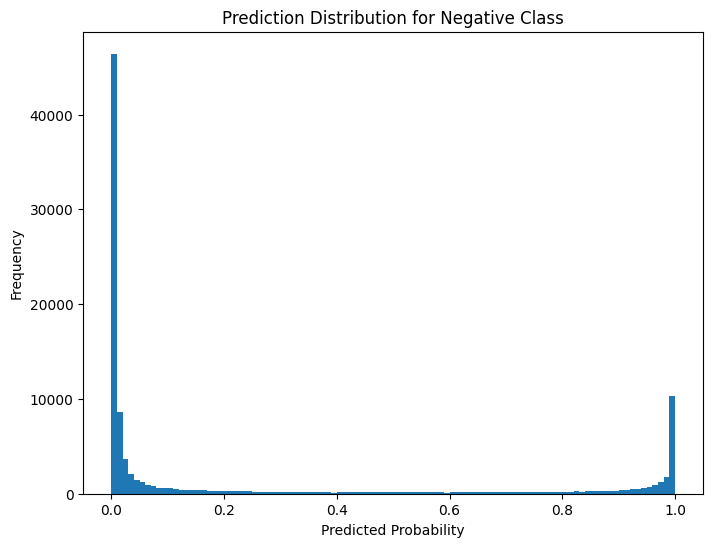

In [50]:
run_ids = [
    "7dzuv8dv", # fold 0
    "8y19trno", # fold 1
    "pcflf218", # fold 2
    "4onrykik", # fold 3
]

for fold, run_id in enumerate(run_ids):
    # dataloader
    valid_dataloader = get_dataloaders_and_stats(fold)

    # models
    runid_model_files = filter_files_by_run_id(model_files, run_id)
    selected_model_files = sort_files_by_valid_loss(runid_model_files)[:3]
    
    for path in selected_model_files:
        run = wandb.init(
            project="isic_lesions_24",
            job_type="evaluate_folds",
            name=f'{run_id}_fold_{fold}_{path.split("/")[-1]}_eval'
        )

        model = SkinClassifier(
            model_name="efficientnet_v2_s"
        )
        model = model.to(device)
        model = torch.compile(model)
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)

        preds, gts = infer_model(model, valid_dataloader)
        score = comp_score(
            pd.DataFrame(gts, columns=["target"]),
            pd.DataFrame(preds, columns=["prediction"]),
            ""
        )
        auroc = roc_auc_score(gts, preds)

        pos_plt = log_positive_dist(preds)
        neg_plt = log_negative_dist(preds)

        wandb.log({
            "pAUC": score,
            "AUROC": auroc,
        })

        wandb.finish()

        model.to("cpu")
        del model
        gc.collect()

    del valid_dataloader
    gc.collect()

In [10]:
run_ids = [
    "7dzuv8dv", # fold 0
    "8y19trno", # fold 1
    "pcflf218", # fold 2
    "4onrykik", # fold 3
]

scores = {}

for fold, run_id in enumerate(run_ids):
    if run_id not in scores.keys():
        scores[run_id] = {}

    # dataloader
    valid_dataloader = get_dataloaders_and_stats(fold)

    # models
    runid_model_files = filter_files_by_run_id(model_files, run_id)
    selected_model_files = sort_files_by_valid_loss(runid_model_files)[:3]
    
    for path in selected_model_files:
        scores[run_id][path] = {}

        model = SkinClassifier(
            model_name="efficientnet_v2_s"
        )
        model = model.to(device)
        model = torch.compile(model)
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)

        preds, gts = infer_model(model, valid_dataloader)
        score = comp_score(
            pd.DataFrame(gts, columns=["target"]),
            pd.DataFrame(preds, columns=["prediction"]),
            ""
        )
        auroc = roc_auc_score(gts, preds)

        scores[run_id][path]["pAUC"] = score
        scores[run_id][path]["AUROC"] = auroc
        
        model.to("cpu")
        del model
        gc.collect()

    del valid_dataloader
    gc.collect()

{'val': 108226}


/tmp/ipykernel_1833968/3251569159.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
  0%|          | 0/846 [00:00<?, ?i

{'val': 98031}


/tmp/ipykernel_1833968/3251569159.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
100%|██████████| 766/766 [01:39<00:

{'val': 93952}


/tmp/ipykernel_1833968/3251569159.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
100%|██████████| 734/734 [01:36<00:

{'val': 100850}


/tmp/ipykernel_1833968/3251569159.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)
100%|██████████| 788/788 [01:42<00:

In [11]:
scores

{'7dzuv8dv': {'../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.1240288019180298_epoch12_fold0.bin': {'pAUC': 0.16111869373862878,
   'AUROC': 0.943292105273589},
  '../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.3086553812026978_epoch10_fold0.bin': {'pAUC': 0.15244860145665723,
   'AUROC': 0.9305807734808577},
  '../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.4547072649002075_epoch4_fold0.bin': {'pAUC': 0.14986881980990427,
   'AUROC': 0.9280249068393832}},
 '8y19trno': {'../models/efficientnet_v2_s_8y19trno_valid_loss1.1930794715881348_epoch23_fold1.bin': {'pAUC': 0.14746145355083382,
   'AUROC': 0.9251488140819472},
  '../models/efficientnet_v2_s_8y19trno_valid_loss1.3220175504684448_epoch20_fold1.bin': {'pAUC': 0.1466457697321176,
   'AUROC': 0.9258922888950151},
  '../models/efficientnet_v2_s_8y19trno_valid_loss1.38202702999115_epoch19_fold1.bin': {'pAUC': 0.15160862151703572,
   'AUROC': 0.9279710347159118}},
 'pcflf218': {'../models/efficientnet_v2_s_pcflf218_valid_loss1.075

In [17]:
ensembles_df = pd.DataFrame(
    columns=[
        "fold0", "fold1", "fold2", "fold3", "val_loss0", "val_loss1", "val_loss2", "val_loss3", "pAUC", "std_pAUC", "AUROC", "atd_AUROC"
    ]
)

ensemble_scores = {}

fold_0_scores = scores["7dzuv8dv"]
fold_1_scores = scores["8y19trno"]
fold_2_scores = scores["pcflf218"]
fold_3_scores = scores["4onrykik"]

In [21]:
list(zip(fold_0_scores, fold_1_scores, fold_2_scores, fold_3_scores))

[('../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.1240288019180298_epoch12_fold0.bin',
  '../models/efficientnet_v2_s_8y19trno_valid_loss1.1930794715881348_epoch23_fold1.bin',
  '../models/efficientnet_v2_s_pcflf218_valid_loss1.0758283138275146_epoch42_fold2.bin',
  '../models/efficientnet_v2_s_4onrykik_valid_loss1.5838444232940674_epoch47_fold3.bin'),
 ('../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.3086553812026978_epoch10_fold0.bin',
  '../models/efficientnet_v2_s_8y19trno_valid_loss1.3220175504684448_epoch20_fold1.bin',
  '../models/efficientnet_v2_s_pcflf218_valid_loss1.1560598611831665_epoch19_fold2.bin',
  '../models/efficientnet_v2_s_4onrykik_valid_loss1.6226918697357178_epoch46_fold3.bin'),
 ('../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.4547072649002075_epoch4_fold0.bin',
  '../models/efficientnet_v2_s_8y19trno_valid_loss1.38202702999115_epoch19_fold1.bin',
  '../models/efficientnet_v2_s_pcflf218_valid_loss1.4912959337234497_epoch9_fold2.bin',
  '../models/efficientn

In [46]:
from itertools import product


# Create a list to store results
results = []

# Calculate the scores for every combination of models
for model_0, model_1, model_2, model_3 in product(fold_0_scores.keys(), fold_1_scores.keys(), fold_2_scores.keys(), fold_3_scores.keys()):
    combined_pAUC = np.mean([fold_0_scores[model_0]['pAUC'], fold_1_scores[model_1]['pAUC'], fold_2_scores[model_2]['pAUC'], fold_3_scores[model_3]['pAUC']])
    combined_AUROC = np.mean([fold_0_scores[model_0]['AUROC'], fold_1_scores[model_1]['AUROC'], fold_2_scores[model_2]['AUROC'], fold_3_scores[model_3]['AUROC']])
    
    # Calculate std deviation
    std_pAUC = np.std([fold_0_scores[model_0]['pAUC'], fold_1_scores[model_1]['pAUC'], fold_2_scores[model_2]['pAUC'], fold_3_scores[model_3]['pAUC']])
    std_AUROC = np.std([fold_0_scores[model_0]['AUROC'], fold_1_scores[model_1]['AUROC'], fold_2_scores[model_2]['AUROC'], fold_3_scores[model_3]['AUROC']])
    
    # Extract val losses from model names
    val_loss0 = float(model_0.split('_')[5][4:])
    val_loss1 = float(model_1.split('_')[5][4:])
    val_loss2 = float(model_2.split('_')[5][4:])
    val_loss3 = float(model_3.split('_')[5][4:])
    
    results.append([model_0, model_1, model_2, model_3, val_loss0, val_loss1, val_loss2, val_loss3, combined_pAUC, std_pAUC, combined_AUROC, std_AUROC])

# Create a DataFrame
ensembles_df = pd.DataFrame(
    results,
    columns=["fold0", "fold1", "fold2", "fold3", "val_loss0", "val_loss1", "val_loss2", "val_loss3", "pAUC", "std_pAUC", "AUROC", "std_AUROC"]
)

In [47]:
ensembles_df.head()

,fold0,fold1,fold2,fold3,val_loss0,val_loss1,val_loss2,val_loss3,pAUC,std_pAUC,AUROC,std_AUROC
0,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.075828,1.583844,0.148804,0.011558,0.927987,0.011820
1,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.075828,1.622692,0.149153,0.011015,0.928913,0.010513
2,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.075828,1.652285,0.148429,0.012150,0.927803,0.012089
3,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.156060,1.583844,0.149706,0.012206,0.928161,0.011892
4,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.156060,1.622692,0.150054,0.011665,0.929086,0.010579


In [49]:
max_pAUC_row = ensembles_df.loc[ensembles_df['pAUC'].idxmax()]
min_std_pAUC_row = ensembles_df.loc[ensembles_df['std_pAUC'].idxmin()]

max_pAUC_row, min_std_pAUC_row

(fold0        ../models/efficientnet_v2_s_7dzuv8dv_valid_los...
 fold1        ../models/efficientnet_v2_s_8y19trno_valid_los...
 fold2        ../models/efficientnet_v2_s_pcflf218_valid_los...
 fold3        ../models/efficientnet_v2_s_4onrykik_valid_los...
 val_loss0                                             1.124029
 val_loss1                                             1.382027
 val_loss2                                              1.15606
 val_loss3                                             1.622692
 pAUC                                                  0.151091
 std_pAUC                                              0.011573
 AUROC                                                 0.929792
 std_AUROC                                             0.010385
 Name: 22, dtype: object,
 fold0        ../models/efficientnet_v2_s_7dzuv8dv_valid_los...
 fold1        ../models/efficientnet_v2_s_8y19trno_valid_los...
 fold2        ../models/efficientnet_v2_s_pcflf218_valid_los...
 fold3        

In [55]:
ensembles_df.sort_values(by='pAUC', ascending=False).head(10)

,fold0,fold1,fold2,fold3,val_loss0,val_loss1,val_loss2,val_loss3,pAUC,std_pAUC,AUROC,std_AUROC
22,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.156060,1.622692,0.151091,0.011573,0.929792,0.010385
21,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.156060,1.583844,0.150743,0.012147,0.928867,0.011776
23,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.156060,1.652285,0.150368,0.012769,0.928682,0.012059
19,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.075828,1.622692,0.150189,0.011002,0.929618,0.010330
4,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.156060,1.622692,0.150054,0.011665,0.929086,0.010579
13,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.322018,1.156060,1.622692,0.149850,0.011716,0.929272,0.010515
18,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.075828,1.583844,0.149841,0.011577,0.928693,0.011713
3,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.193079,1.156060,1.583844,0.149706,0.012206,0.928161,0.011892
12,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.322018,1.156060,1.583844,0.149502,0.012248,0.928347,0.011850
20,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.124029,1.382027,1.075828,1.652285,0.149466,0.012200,0.928509,0.011995


In [54]:
ensembles_df.sort_values(by='std_pAUC', ascending=True).head(10)

,fold0,fold1,fold2,fold3,val_loss0,val_loss1,val_loss2,val_loss3,pAUC,std_pAUC,AUROC,std_AUROC
70,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.322018,1.491296,1.622692,0.145135,0.007791,0.922146,0.005260
61,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.193079,1.491296,1.622692,0.145339,0.007839,0.921960,0.005136
43,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.308655,1.322018,1.491296,1.622692,0.145780,0.008250,0.922785,0.006034
34,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.308655,1.193079,1.491296,1.622692,0.145984,0.008279,0.922599,0.005946
79,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.382027,1.491296,1.622692,0.146376,0.008311,0.922666,0.005690
69,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.322018,1.491296,1.583844,0.144787,0.008377,0.921221,0.006658
60,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.193079,1.491296,1.583844,0.144991,0.008430,0.921035,0.006535
52,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.308655,1.382027,1.491296,1.622692,0.147021,0.008650,0.923305,0.006360
64,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.322018,1.075828,1.622692,0.146136,0.008798,0.925282,0.006677
55,../models/efficientnet_v2_s_7dzuv8dv_valid_los...,../models/efficientnet_v2_s_8y19trno_valid_los...,../models/efficientnet_v2_s_pcflf218_valid_los...,../models/efficientnet_v2_s_4onrykik_valid_los...,1.454707,1.193079,1.075828,1.622692,0.146340,0.008817,0.925096,0.006668


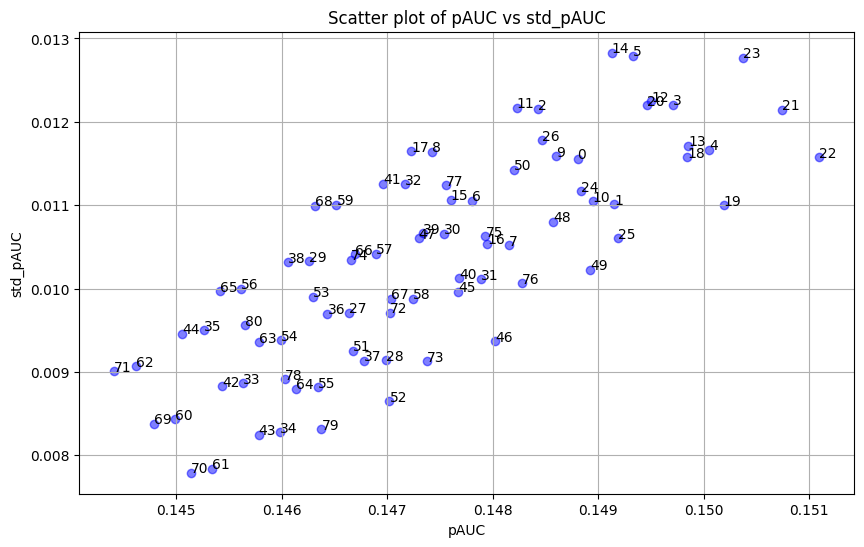

In [57]:
import matplotlib.pyplot as plt

# Scatter plot of pAUC vs std_pAUC
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(ensembles_df['pAUC'], ensembles_df['std_pAUC'], c='blue', alpha=0.5)
plt.xlabel('pAUC')
plt.ylabel('std_pAUC')
plt.title('Scatter plot of pAUC vs std_pAUC')

# Optionally, add annotations to the points
for i, row in ensembles_df.iterrows():
    plt.annotate(i, (row['pAUC'], row['std_pAUC']))

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [59]:
ensembles_df.loc[46]

fold0        ../models/efficientnet_v2_s_7dzuv8dv_valid_los...
fold1        ../models/efficientnet_v2_s_8y19trno_valid_los...
fold2        ../models/efficientnet_v2_s_pcflf218_valid_los...
fold3        ../models/efficientnet_v2_s_4onrykik_valid_los...
val_loss0                                             1.308655
val_loss1                                             1.382027
val_loss2                                             1.075828
val_loss3                                             1.622692
pAUC                                                  0.148022
std_pAUC                                              0.009368
AUROC                                                  0.92644
std_AUROC                                             0.007078
Name: 46, dtype: object

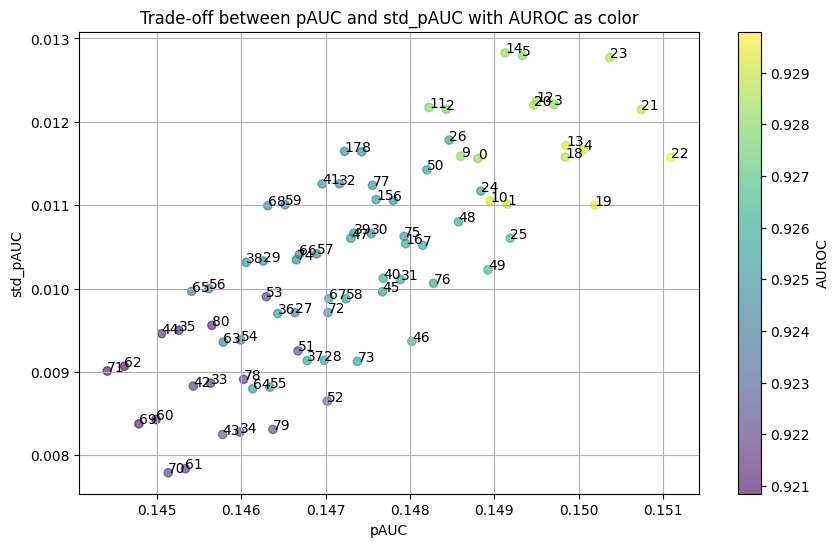

In [65]:
import matplotlib.pyplot as plt

# Scatter plot of pAUC vs std_pAUC with color indicating mean score
plt.figure(figsize=(10, 6))
sc = plt.scatter(ensembles_df['pAUC'], ensembles_df['std_pAUC'], c=ensembles_df['AUROC'], cmap='viridis', alpha=0.6)
plt.colorbar(sc, label='AUROC')
plt.xlabel('pAUC')
plt.ylabel('std_pAUC')
plt.title('Trade-off between pAUC and std_pAUC with AUROC as color')

# Optionally, add annotations to the points
for i, row in ensembles_df.iterrows():
    plt.annotate(i, (row['pAUC'], row['std_pAUC']))

plt.grid(True)

In [62]:
ensembles_df.loc[22].values

array(['../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.1240288019180298_epoch12_fold0.bin',
       '../models/efficientnet_v2_s_8y19trno_valid_loss1.38202702999115_epoch19_fold1.bin',
       '../models/efficientnet_v2_s_pcflf218_valid_loss1.1560598611831665_epoch19_fold2.bin',
       '../models/efficientnet_v2_s_4onrykik_valid_loss1.6226918697357178_epoch46_fold3.bin',
       1.1240288019180298, 1.38202702999115, 1.1560598611831665,
       1.6226918697357178, 0.1510910877257267, 0.011572739431317385,
       0.9297919871448301, 0.010385483732199927], dtype=object)

In [63]:
ensembles_df.loc[70].values

array(['../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.4547072649002075_epoch4_fold0.bin',
       '../models/efficientnet_v2_s_8y19trno_valid_loss1.3220175504684448_epoch20_fold1.bin',
       '../models/efficientnet_v2_s_pcflf218_valid_loss1.4912959337234497_epoch9_fold2.bin',
       '../models/efficientnet_v2_s_4onrykik_valid_loss1.6226918697357178_epoch46_fold3.bin',
       1.4547072649002075, 1.3220175504684448, 1.4912959337234497,
       1.6226918697357178, 0.1451351191007001, 0.007791241214082257,
       0.9221458674933476, 0.005259947539946435], dtype=object)

In [72]:
run = wandb.init(
    project="isic_lesions_24",
    job_type="evaluate_folds",
)

wandb.log({"ensembles_4_fold_combinations": ensembles_df})
wandb.finish()

In [100]:
ensembles_df.loc[
    (ensembles_df.val_loss0 == ensembles_df.val_loss0.min()) & 
    (ensembles_df.val_loss1 == ensembles_df.val_loss1.min()) &
    (ensembles_df.val_loss2 == ensembles_df.val_loss2.min()) & 
    (ensembles_df.val_loss3 == ensembles_df.val_loss3.min())
].values

array([['../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.1240288019180298_epoch12_fold0.bin',
        '../models/efficientnet_v2_s_8y19trno_valid_loss1.1930794715881348_epoch23_fold1.bin',
        '../models/efficientnet_v2_s_pcflf218_valid_loss1.0758283138275146_epoch42_fold2.bin',
        '../models/efficientnet_v2_s_4onrykik_valid_loss1.5838444232940674_epoch47_fold3.bin',
        1.1240288019180298, 1.1930794715881348, 1.0758283138275146,
        1.5838444232940674, 0.14880438026686002, 0.011558360130348869,
        0.9279874146264983, 0.011819859913538585]], dtype=object)

In [101]:
ensembles_df.loc[46].values

array(['../models/efficientnet_v2_s_7dzuv8dv_valid_loss1.3086553812026978_epoch10_fold0.bin',
       '../models/efficientnet_v2_s_8y19trno_valid_loss1.38202702999115_epoch19_fold1.bin',
       '../models/efficientnet_v2_s_pcflf218_valid_loss1.0758283138275146_epoch42_fold2.bin',
       '../models/efficientnet_v2_s_4onrykik_valid_loss1.6226918697357178_epoch46_fold3.bin',
       1.3086553812026978, 1.38202702999115, 1.0758283138275146,
       1.6226918697357178, 0.14802179209484284, 0.00936778018808251,
       0.9264403928713063, 0.007077576058897397], dtype=object)